In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import time
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),  # Converting grayscale image to RGB
        transforms.Resize((224, 224)),  # Resizeing images to 224x224
        transforms.ToTensor(),  # Converting image to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  #Normalization of VGG mean/std
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
}

In [ ]:
data_dir = r"C:\Users\Intel6\Downloads\DL project_aug1\DL project"
train_dir = os.path.join(data_dir, 'training')
val_dir = os.path.join(data_dir, 'testing')

In [ ]:
image_datasets = {
    'train': datasets.ImageFolder(train_dir, data_transforms['train']),
    'val': datasets.ImageFolder(val_dir, data_transforms['val']),
}

In [ ]:
batch_size = 32
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=False),
}


In [ ]:
num_classes = len(image_datasets['train'].classes)


In [ ]:
model = models.vgg19(pretrained=False)  # Set the pretrained=False to train from scratch
print(f"Number of training images: {len(image_datasets['train'])}")
print(f"Number of validation images: {len(image_datasets['val'])}")


C:\Users\Intel6\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Intel6\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Number of training images: 2870
Number of validation images: 394


In [ ]:
for param in model.parameters():
    param.requires_grad = True

model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes) # Modifying the classifier for the specific task
model = model.to(device) # Moving model to the selected device GPU or CPU

criterion = nn.CrossEntropyLoss() # Define the loss function
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001) #optiizer

num_epochs = 20 # Setting the number of epochs at 20 for training
train_loss_history = [] # Initialize the lists to track loss values for plotting
val_loss_history = []

Epoch 1/20
----------
train Loss: 1.8531 Acc: 0.3084 F1: 0.3004
val Loss: 1.3577 Acc: 0.3579 F1: 0.2962

Epoch 2/20
----------
train Loss: 1.2560 Acc: 0.3822 F1: 0.3808
val Loss: 1.3978 Acc: 0.4010 F1: 0.3449

Epoch 3/20
----------
train Loss: 1.2183 Acc: 0.4049 F1: 0.4055
val Loss: 1.3330 Acc: 0.4391 F1: 0.4060

Epoch 4/20
----------
train Loss: 1.1896 Acc: 0.4056 F1: 0.4000
val Loss: 1.4925 Acc: 0.3223 F1: 0.3055

Epoch 5/20
----------
train Loss: 1.2056 Acc: 0.4317 F1: 0.3857
val Loss: 1.4175 Acc: 0.4061 F1: 0.3935

Epoch 6/20
----------
train Loss: 1.2964 Acc: 0.3348 F1: 0.2858
val Loss: 1.4252 Acc: 0.3503 F1: 0.3129

Epoch 7/20
----------
train Loss: 1.2734 Acc: 0.3449 F1: 0.3048
val Loss: 1.4492 Acc: 0.3883 F1: 0.3588

Epoch 8/20
----------
train Loss: 1.2784 Acc: 0.3348 F1: 0.2791
val Loss: 1.4833 Acc: 0.4036 F1: 0.3699

Epoch 9/20
----------
train Loss: 1.2882 Acc: 0.3338 F1: 0.2867
val Loss: 1.4457 Acc: 0.3299 F1: 0.2965

Epoch 10/20
----------
train Loss: 1.2698 Acc: 0.3387 F

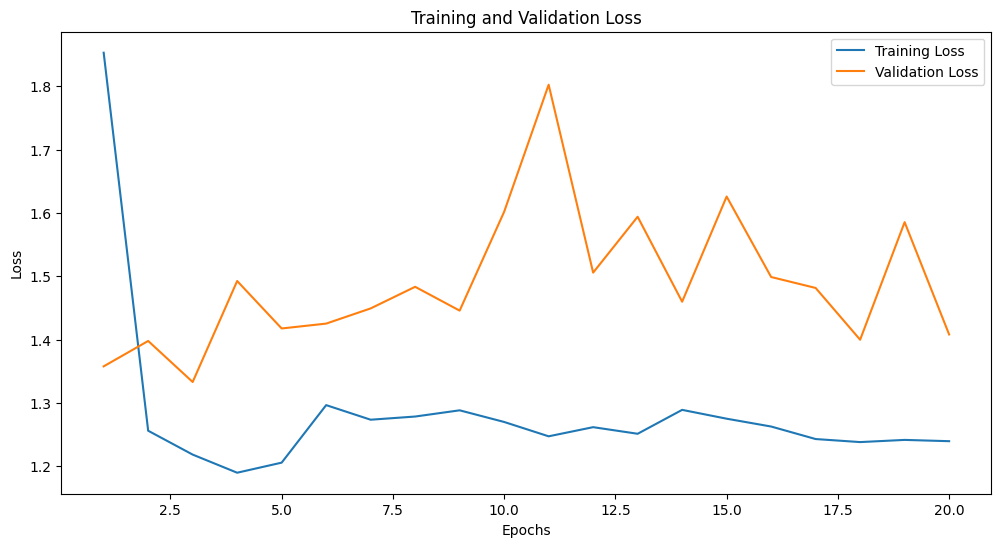

Final Accuracy on Validation Set: 43.91%


In [ ]:
def train_model(model, criterion, optimizer, num_epochs=20):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:       # Each epoch has a training and validation phase
            model.train() if phase == 'train' else model.eval()

            running_loss = 0.0
            running_corrects = 0
            all_labels = []
            all_preds = []

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train': # Backward + optimize (only in the training phase)
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                all_labels.extend(labels.cpu().numpy()) # Collect all labels and predictions for F1 scores
                all_preds.extend(preds.cpu().numpy())

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            # F1 Score
            f1 = f1_score(all_labels, all_preds, average='weighted')

            if phase == 'train': # Save the loss history to plot the graph
                train_loss_history.append(epoch_loss)
            else:
                val_loss_history.append(epoch_loss)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {f1:.4f}')

            # Deep copy the model if it has the best accuracy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts) # Loading the best model weights

    return model

best_model = train_model(model, criterion, optimizer, num_epochs)
torch.save(best_model.state_dict(), 'vgg19_best_model.pth')

# Plotting loss graphs
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs+1), train_loss_history, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Evaluation on the validation set
model.eval()
correct = 0
total = 0
for inputs, labels in dataloaders['val']:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (preds == labels).sum().item()

final_accuracy = correct / total
print(f'Final Accuracy on Validation Set: {final_accuracy * 100:.2f}%')